Epoch 4096/65536


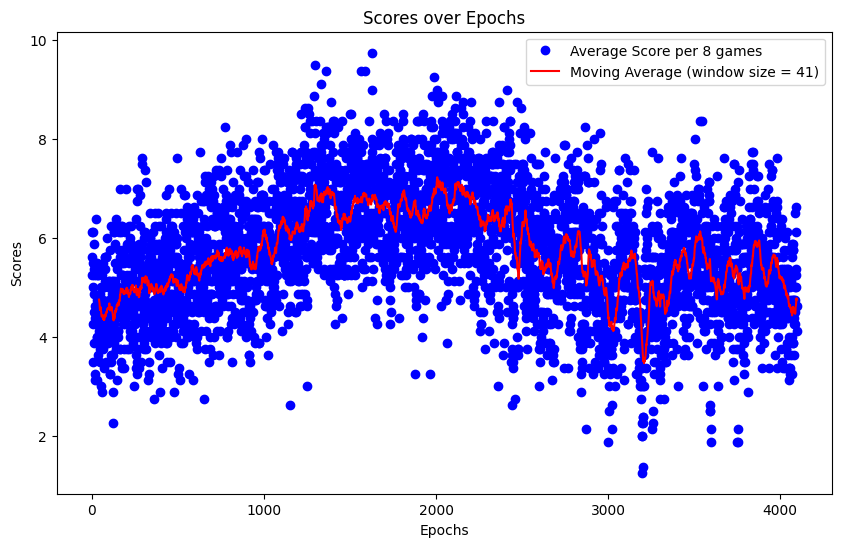

Epoch 8192/65536


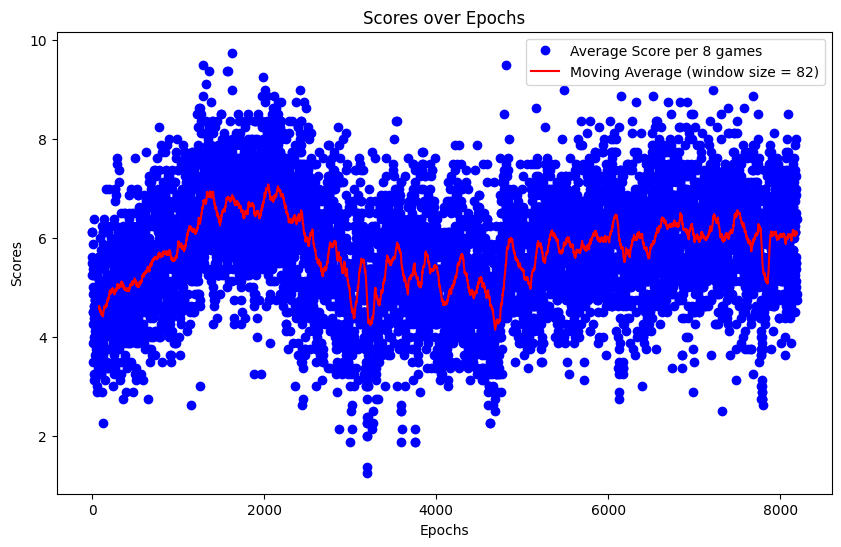

Epoch 12288/65536


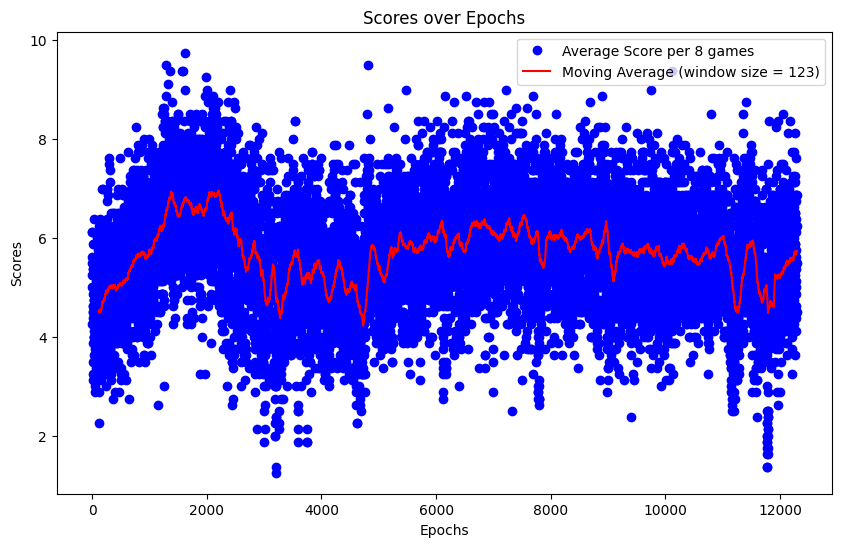

Epoch 16384/65536


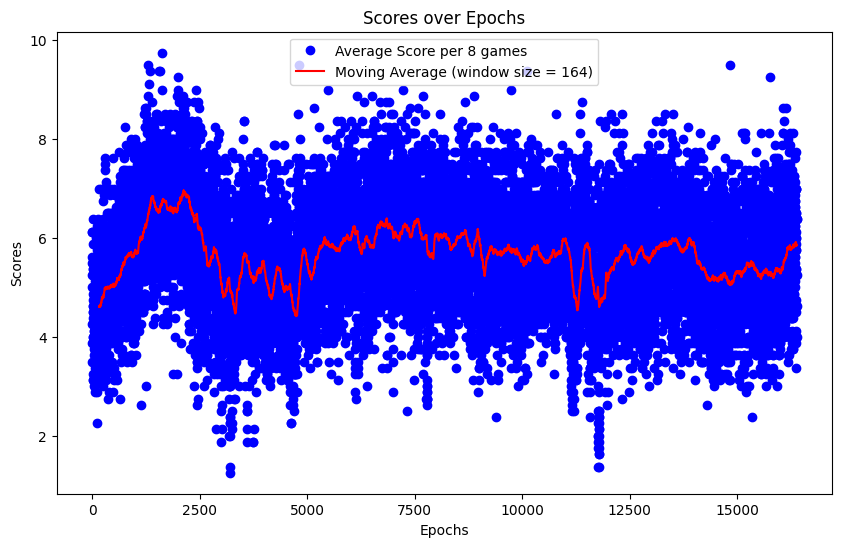

Epoch 20480/65536


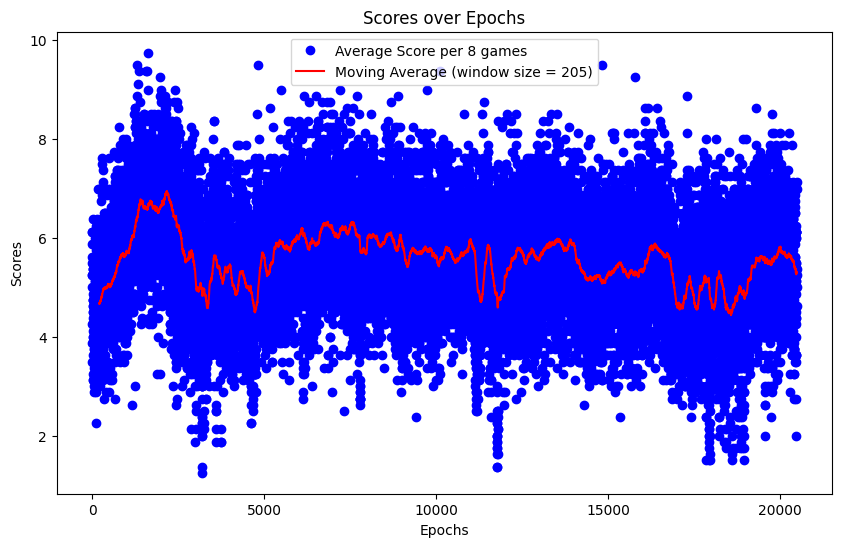

Epoch 24576/65536


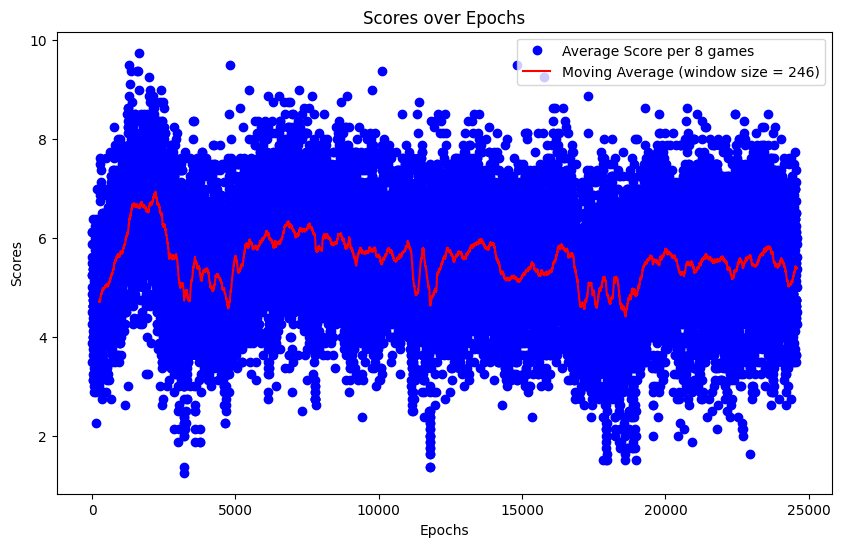

Epoch 28672/65536


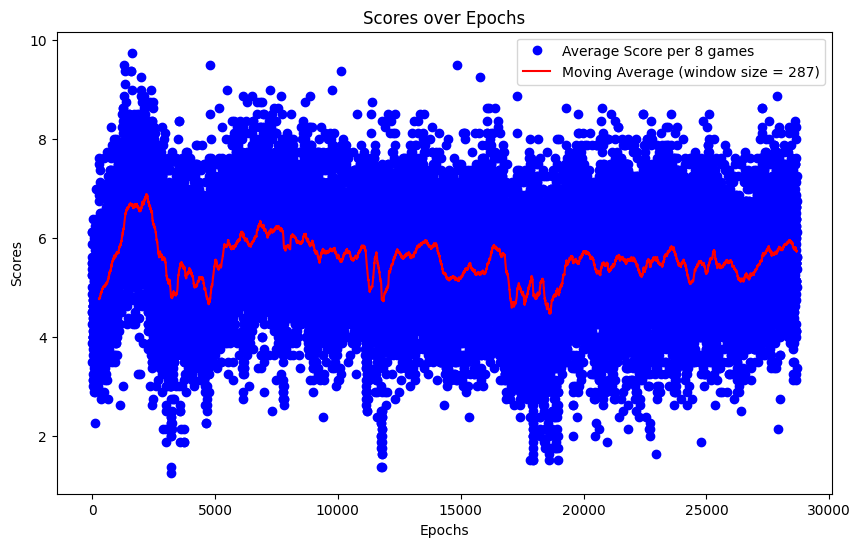

Epoch 32768/65536


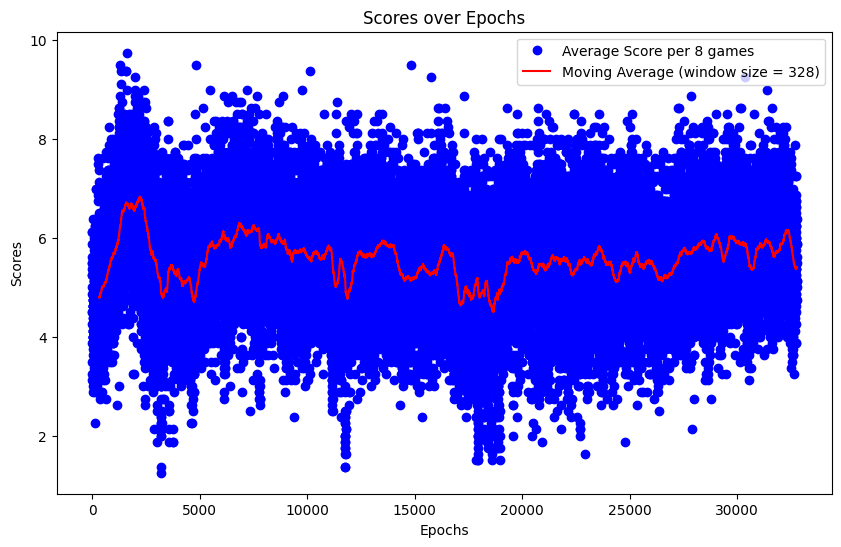

Epoch 36864/65536


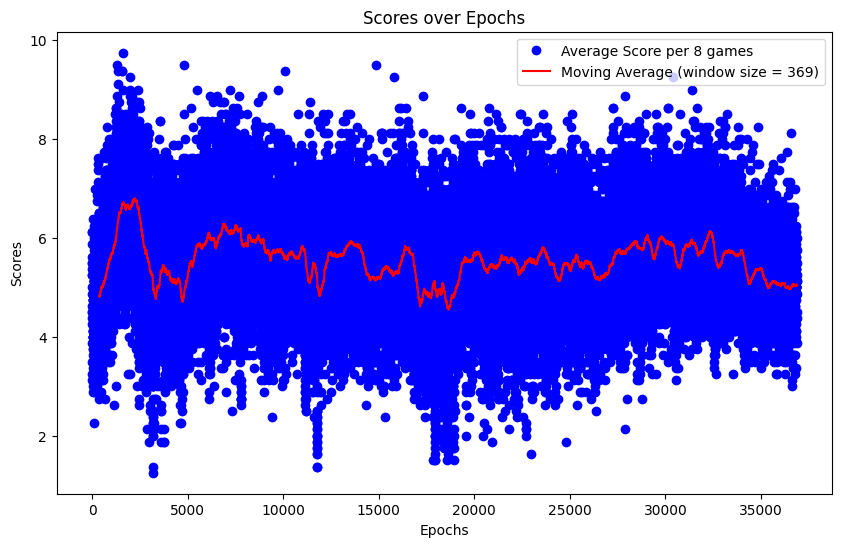

Epoch 40960/65536


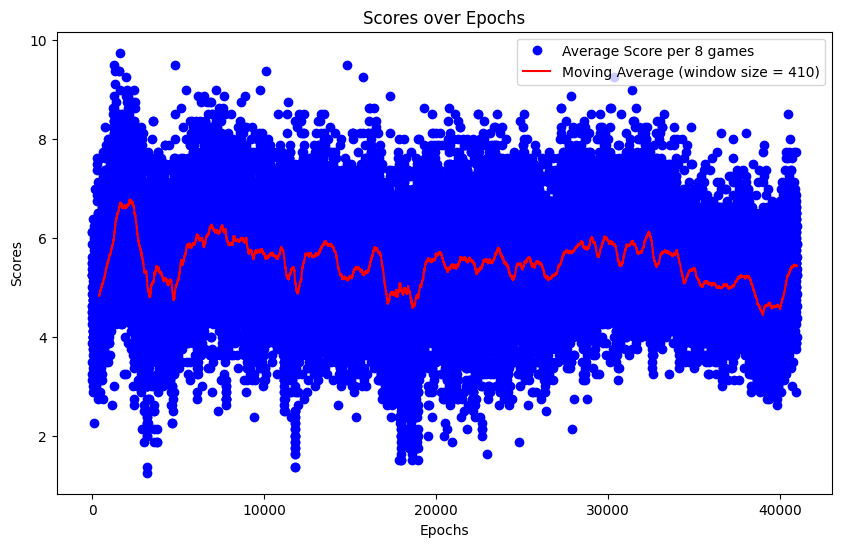

Epoch 45056/65536


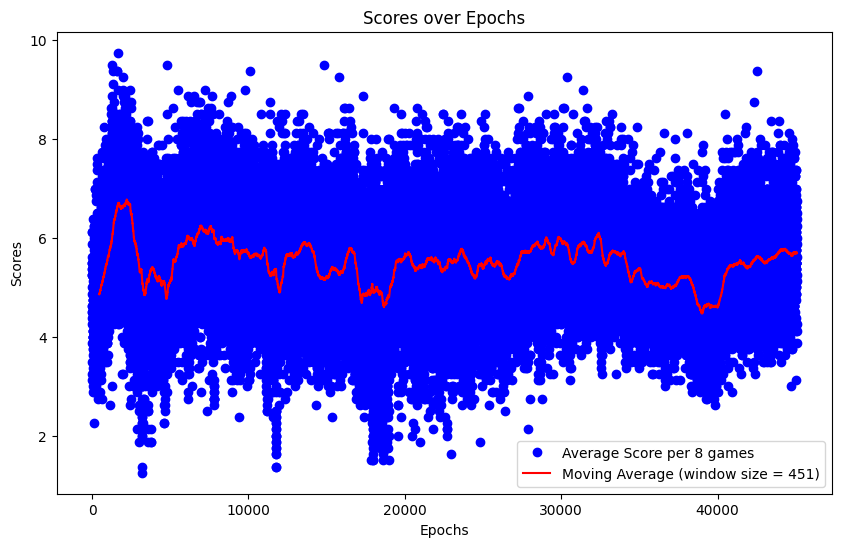

Epoch 49152/65536


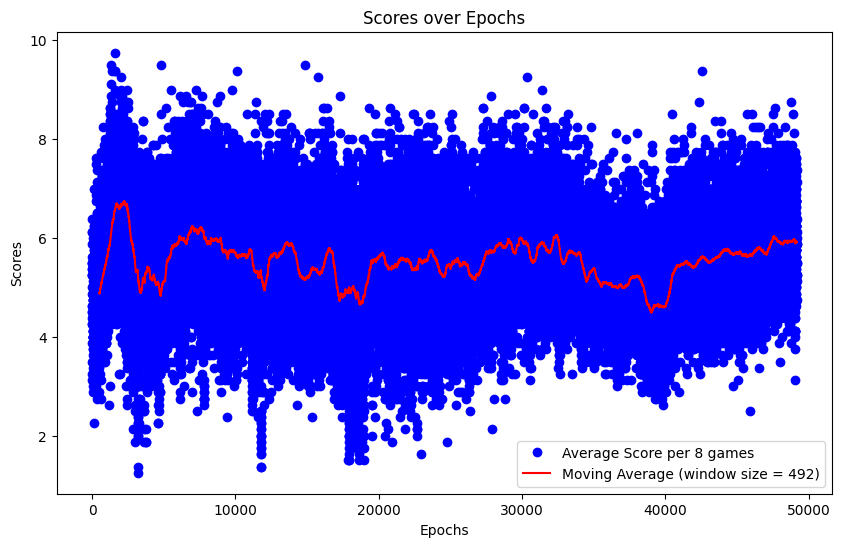

Epoch 53248/65536


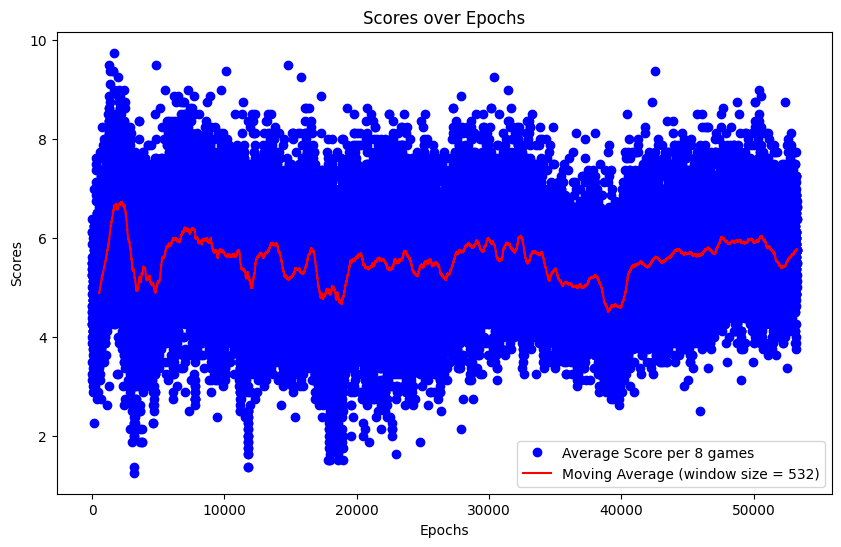

Epoch 57344/65536


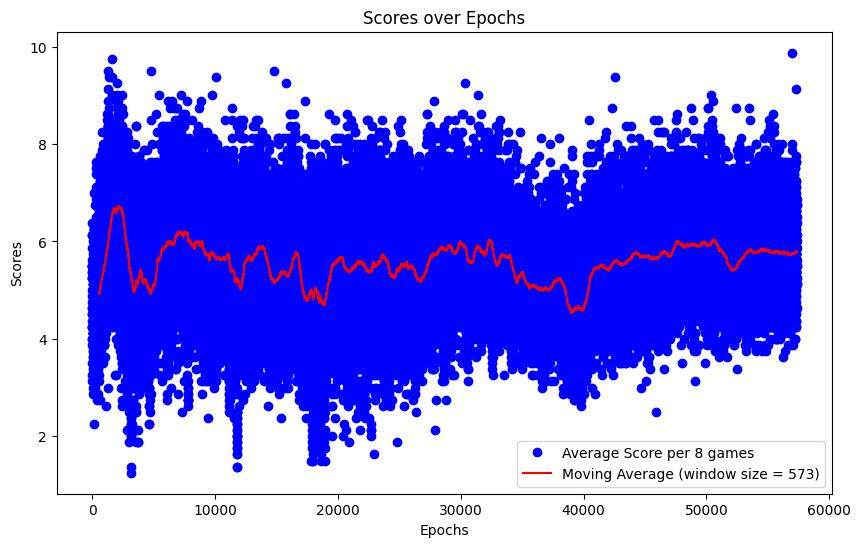

Epoch 61440/65536


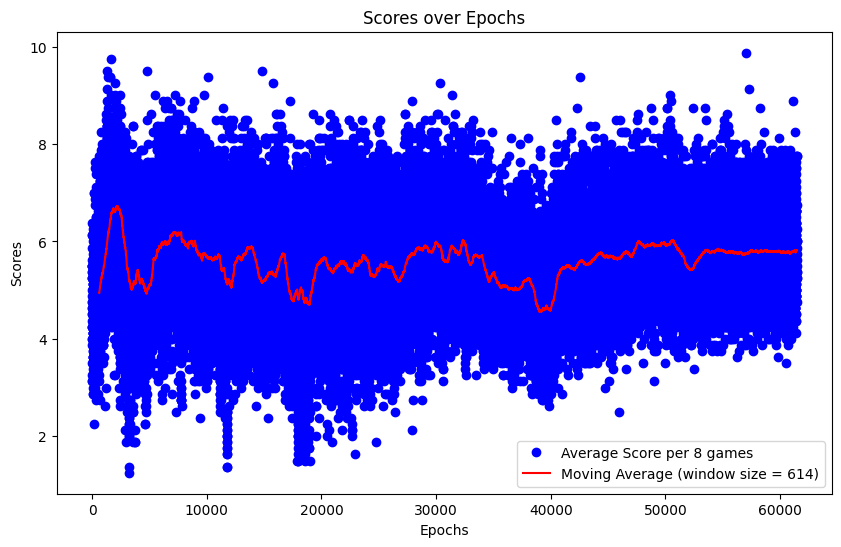

Epoch 65536/65536


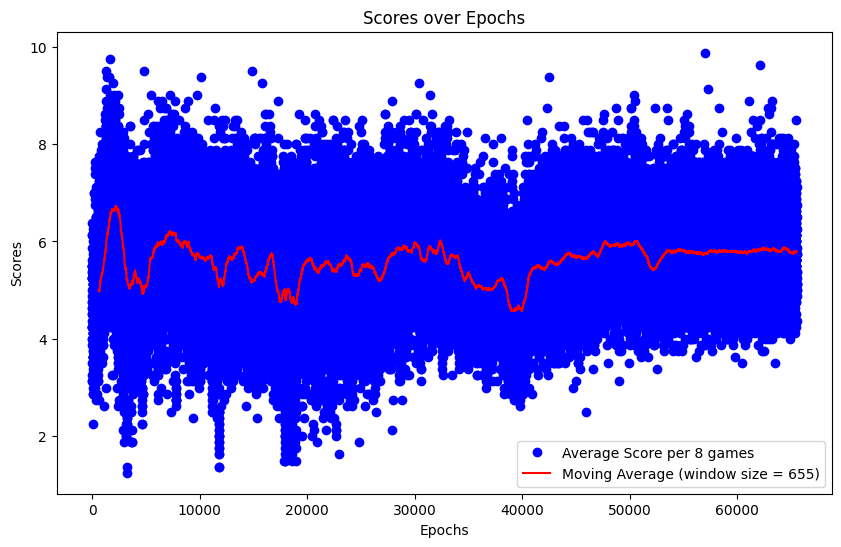

Highest Score: 18
Best Board Configuration:
  1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 |  12 |  13 |  14 |  15 |  16 |  17 |  18 |  19 |  20
 46 |  57 |  92 | 166 | 169 | 380 | 450 | 464 |  -  | 471 | 502 | 502 | 541 | 643 | 644 | 791 |  -  | 866 | 891 | 904



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import importlib
import numpy as np
from collections import deque

# Re-import the game class, to ensure the cache is cleared
import game_simulation
importlib.reload(game_simulation)
from game_simulation import NumberPlacementGame

# Define the neural network architecture
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(21, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 20)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        
    def forward(self, x):
        # Define forward pass with Leaky ReLU activations
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.output(x)
        return x
    
# Function to mask invalid moves by setting their output to negative infinity
def mask_invalid_moves(game, output, num):
    for i in range(20):
        if game.board[i] is not None or not game.validate_placement(i, num)[0]:
            output[i] = float('-inf')
    return output

# Training function using Q-learning and epsilon-greedy exploration
def train(game, model, target_model, optimizer, epochs, memory=64, milestones=5, epsilon_resets=1, 
          games_per_epoch=1, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, reset_epsilon=0.5, 
          gamma=0.99, update_target_every=1000):
    
    scores = []  # List to keep track of scores
    milestone_interval = epochs // milestones  # Interval for printing milestones
    reset_interval = epochs // epsilon_resets  # Interval for resetting epsilon
    highest_score = 0  # Track highest score achieved
    best_board = None  # Track board configuration of highest score
    replay_buffer = deque(maxlen=10000)  # Replay buffer for experience replay
    
    for epoch in range(epochs):
        if epoch > 0 and (epoch % reset_interval == 0):
            epsilon = reset_epsilon
            print(f"Epsilon reset to {reset_epsilon} at epoch {epoch}")

        epoch_scores = []  # Track scores for the current epoch
        epoch_game_experience = []  # Collect experiences for the current epoch
        for _ in range(games_per_epoch):
            game.reset()  # Reset the game
            score = 0  # Initialize score
            game_experience = []  # Track game experiences
            while True:
                game.num = random.randint(1, 999)
                if game.check_game_over(game.num):
                    break
                
                # Get current game state
                board_state = torch.tensor([x if x is not None else 0 for x in game.board] + [game.num], dtype=torch.float32) / 999.0
                
                # Forward pass to get model output
                output = model(board_state)
                output = mask_invalid_moves(game, output, game.num)  # Mask invalid moves
                
                if random.random() < epsilon:
                    # Choose random valid move with probability epsilon
                    position = random.choice([i for i in range(20) if output[i] != float('-inf')])
                else:
                    # Choose the best move according to the model
                    position = output.argmax().item()

                # Validate and place the number on the board
                valid, _ = game.validate_placement(position, game.num)
                if valid:
                    game.board[position] = game.num
                    score += 1
                else:
                    break

                if score > highest_score:
                    highest_score = score  # Update highest score
                    best_board = game.board.copy()  # Update best board configuration

                # Get the next game state
                next_board_state = torch.tensor([x if x is not None else 0 for x in game.board] + [game.num], dtype=torch.float32) / 999.0
                done = game.check_game_over(game.num)  # Check if the game is over
                game_experience.append((board_state, position, next_board_state, done))  # Append game experiences for the epoch
            
            epoch_scores.append(score)  # Append score for the epoch
            epoch_game_experience.extend(game_experience)

        # Calculate the average score for the epoch
        avg_score = sum(epoch_scores) / games_per_epoch

        # Assign the average score as the reward for all experiences in the epoch
        for board_state, position, next_board_state, done in epoch_game_experience:
            reward = avg_score
            replay_buffer.append((board_state, position, reward, next_board_state, done))

        # Train the model with experiences from the replay buffer
        if len(replay_buffer) >= memory:
            batch = random.sample(replay_buffer, memory)
            for board_state, position, reward, next_board_state, done in batch:
                target = reward
                if not done:
                    with torch.no_grad():
                        # Use the primary network to select the next action
                        next_action = model(next_board_state).argmax().item()  
                        # Use the target network to evaluate the value of the next state
                        next_q_values = target_model(next_board_state) 
                        next_max_q = next_q_values[next_action].item()
                    target += gamma * next_max_q
                
                output = model(board_state)
                loss = (target - output[position]) ** 2  # Calculate loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay  # Decay epsilon

        scores.append(avg_score)  # Track the average score for the epoch

        if (epoch + 1) % milestone_interval == 0:
            print(f"Epoch {epoch + 1}/{epochs}")
            plot_scores(scores, games_per_epoch, window_size=round(epoch/100))
        
        if epoch % update_target_every == 0:
            target_model.load_state_dict(model.state_dict())  # Update the target model

    print("Highest Score:", highest_score)
    print("Best Board Configuration:")
    game.board = best_board
    game.print_board()
    
    return scores

# Function to plot scores over epochs
def plot_scores(scores, games_per_epoch, window_size=10):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(scores) + 1)
    plt.plot(epochs, scores, 'bo', label=f'Average Score per {games_per_epoch} games')
    if len(scores) >= window_size:
        moving_avg = np.convolve(scores, np.ones(window_size) / window_size, mode='valid')
        valid_epochs = range(window_size, len(scores) + 1)
        plt.plot(valid_epochs, moving_avg, 'r-', label=f'Moving Average (window size = {window_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Scores over Epochs')
    plt.legend()
    plt.show()

# Training setup
game = NumberPlacementGame()
model = NeuralNet()
target_model = NeuralNet()
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Train and graph scores over epochs
scores = train(game, model, target_model, optimizer, epochs=2**16, memory=128, games_per_epoch=8, 
               milestones=16, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, 
               gamma=0.99, epsilon_resets=1, reset_epsilon=0.1)